# Project Network Tour of Data Sciences

## Students

* Team: `6`
* Students: `Gabor Csordas`, `Maëlle Le Clainche`, `Nicolas Fontbonne`, `Marie Sadler`
* Dataset:`Flights routes`

## Presentation of the project

We analyze the *Airline Route Mapper Route Database* which maps 3'321 airports (nodes) worldwide with their respective connections (67'663 connections corresponding to 19'256 edges) operated by 548 airlines \cite{openflights_dataset}. Some of these airlines have joined each other to form passenger airline alliances which for instance facilitates flight connections for multi stop flights. As of today three major airline alliances exist, Star Alliance (SA), SkyTeam (ST), and One World (OW).

We try to answer several questions regarding the prevalence of these alliances in the flight network and in this notebook we go through them one by one. Each question is shortly explained, followed by a strategy on how we answer it. 

- [0- Loading libraries and data](#Part0)


- [1- How prevalent are the alliances in the global flight route network?](#Part1)

    - [Airlines distribution](#Part1-1)
    - [Network properties of the alliance’s flight routes](#Part1-2)
    - [Proportion of airports served by alliance-airlines](#Part1-3)

    
- [2- Is the alliance business a hub thing?](#Part2)


- [3- Which part of the world is dominated by who, and what is a likely expansion?](#Part3)

    - [Geographic distribution of the alliances](#Part3-1)
    - [Airport expansion of the alliances predicted through label propagation](#Part3-2)
    - [Assign airlines to alliances](#Part3-3)

- [4- Can the alliances be predicted from the construction of an airline network?](#Part4)

## 0- Loading libraries and data <a id='Part0'></a>

### Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
import random
import warnings
import folium
warnings.filterwarnings('ignore')

### Data

In [2]:
# routes
routes = pd.read_csv('data/routes.dat', sep=',', encoding='utf-8')
routes.columns = ['Airline','AirlineID','SourceAirport','SourceAirportID','DestinationAirport','DestinationAirportID','Codeshare','Stops','Equipment']
routes.head()

Airline AirlineID SourceAirport SourceAirportID DestinationAirport  \
0      2B       410           ASF            2966                KZN   
1      2B       410           ASF            2966                MRV   
2      2B       410           CEK            2968                KZN   
3      2B       410           CEK            2968                OVB   
4      2B       410           DME            4029                KZN   

  DestinationAirportID Codeshare  Stops Equipment  
0                 2990       NaN      0       CR2  
1                 2962       NaN      0       CR2  
2                 2990       NaN      0       CR2  
3                 4078       NaN      0       CR2  
4                 2990       NaN      0       CR2

In [3]:
# airlines
airlines = pd.read_csv('data/airlines.dat', sep=',', encoding='utf-8')
airlines.columns = ['Airline ID', 'Name', 'Alias',  'IATA', 'ICAO','Callsign','Country','Active']
airlines.head()

Airline ID                                          Name Alias IATA ICAO  \
0           1                                Private flight    \N    -  NaN   
1           2                                   135 Airways    \N  NaN  GNL   
2           3                                 1Time Airline    \N   1T  RNX   
3           4  2 Sqn No 1 Elementary Flying Training School    \N  NaN  WYT   
4           5                               213 Flight Unit    \N  NaN  TFU   

  Callsign         Country Active  
0      NaN             NaN      Y  
1  GENERAL   United States      N  
2  NEXTIME    South Africa      Y  
3      NaN  United Kingdom      N  
4      NaN          Russia      N

In [4]:
# airport
airports = pd.read_csv('data/airports.dat', sep=',', encoding='utf-8')
airports.columns = ['Airport ID', 'Name', 'City', 'Country',  'IATA', 'ICAO','Latitude','Longitude','Altitude', 'Timezone','DST', 'Tz database time zone', 'Type', 'Source']
airports.head()

Airport ID                                         Name          City  \
0           2                               Madang Airport        Madang   
1           3                 Mount Hagen Kagamuga Airport   Mount Hagen   
2           4                               Nadzab Airport        Nadzab   
3           5  Port Moresby Jacksons International Airport  Port Moresby   
4           6                  Wewak International Airport         Wewak   

            Country IATA  ICAO  Latitude   Longitude Altitude Timezone DST  \
0  Papua New Guinea  MAG  AYMD -5.207080  145.789001       20       10   U   
1  Papua New Guinea  HGU  AYMH -5.826790  144.296005     5388       10   U   
2  Papua New Guinea  LAE  AYNZ -6.569803  146.725977      239       10   U   
3  Papua New Guinea  POM  AYPY -9.443380  147.220001      146       10   U   
4  Papua New Guinea  WWK  AYWK -3.583830  143.669006       19       10   U   

  Tz database time zone     Type       Source  
0  Pacific/Port_Moresby  airport  OurAirports  
1  Pacific/Port_Moresby  airport  OurAirports  
2  Pacific/Port_Moresby  airport  OurAirports  
3  Pacific/Port_Moresby  airport  OurAirports  
4  Pacific/Port_Moresby  airport  OurAirports

In [5]:
# alliances
alliances = pd.read_csv('data/alliances.dat', sep=',', encoding='utf-8')
print('Number of airlines in an alliance: ', alliances.IATA.nunique())
print('Number of airlines per Alliance: ')
print(alliances.groupby(['Alliance']).count())
alliances.head()

Number of airlines in an alliance:  60
Number of airlines per Alliance: 
               IATA   Region
Alliance                    
One World        14       14
SkyTeam          20       20
Star Alliance    26       26


Alliance IATA        Region
0  Star Alliance   JP        Europe
1  Star Alliance   A3        Europe
2  Star Alliance   AC  NorthAmerica
3  Star Alliance   CA          Asia
4  Star Alliance   NZ          Asia

## 1- How prevalent are the alliances in the global flight route network? <a id='Part1'></a>

Create a subnetwork for each individual alliance, which integrates all the edges/flights and nodes/airports that are flown and served, respectively, by an alliance airline member. Analyse the network properties and do comparisons between each alliance subnetwork, the whole alliance network and the whole flight network. 

**Strategy**

First we merge the alliance information to the route dataframe. We then create a weighted adjacency matrix which will be a 3D tensor with dimensions {source, destination, alliance}. That way we can keep the weight intact for each flight.

The 'alliance' dimension of the adjacency matrix is attributed as follows:

* No edges = 0
* No alliances = 1
* Star Alliance = 2
* One World = 3
* SkyTeam = 4

In [6]:
# merge alliance data to the route dataframe
routes_alce = pd.merge(routes, alliances, left_on = 'Airline', right_on = 'IATA', how = 'left')
print('Number of edges before the merge and after: ', routes.Airline.count(), routes_alce.Airline.count())
print('Number of alliances-airlines found in the route data: ', routes_alce[~routes_alce.IATA.isnull()].IATA.nunique())
print('Number of flights (edges) flown by alliances-airlines: ', routes_alce[~routes_alce.IATA.isnull()].Airline.count())

# create df with only alliances airlines
routes_alce_only = routes_alce[~routes_alce.IATA.isnull()]

Number of edges before the merge and after:  67662 67662
Number of alliances-airlines found in the route data:  60
Number of flights (edges) flown by alliances-airlines:  29349


In [7]:
# create 3D - adjacency matrix
routes_alce = routes_alce.fillna("None")
routes_alce.head(2)
# import of source and destination airport
source_airports = routes[['SourceAirport']]
source_airports = source_airports.rename(columns={'SourceAirport':'Airport'})

dest_airports = routes[['DestinationAirport']]
dest_airports = dest_airports.rename(columns={'DestinationAirport':'Airport'})

# creation of a dataframe with all airport and airport_idx 
# (we use airport_idx insteed of airportID because some airports have no airportID)
airportsID = pd.concat([source_airports,dest_airports]).drop_duplicates().reset_index().drop(columns=['index']).reset_index()
airportsID = airportsID.set_index('Airport').rename(columns={'index':'airportsID'})

alliances_idx = {"None":1, "Star Alliance":2, "One World":3, "SkyTeam":4}

n_nodes = len(airportsID)
adjacency = np.zeros((n_nodes, n_nodes, 5), dtype=int)
for idx,row in routes_alce.iterrows():
    
    idx_source = airportsID.loc[row.SourceAirport, "airportsID"]
    idx_dest = airportsID.loc[row.DestinationAirport, "airportsID"]
    category = alliances_idx[row.Alliance]
    
    adjacency[idx_source, idx_dest, category] += 1
    adjacency[idx_dest, idx_source, category] += 1

In [8]:
# example of the adjacency matrix of the flights not belonging to an alliance
adjacency[:10, :10, 1]

array([[0, 0, 2, 0, 0, 0, 2, 2, 2, 0],
       [0, 0, 2, 0, 0, 0, 2, 0, 0, 0],
       [2, 2, 0, 6, 2, 4, 6, 6, 4, 2],
       [0, 0, 6, 0, 0, 2, 2, 2, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 2, 2, 2],
       [0, 0, 4, 2, 0, 0, 0, 0, 0, 0],
       [2, 2, 6, 2, 0, 0, 0, 4, 0, 0],
       [2, 0, 6, 2, 2, 0, 4, 0, 0, 2],
       [2, 0, 4, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 2, 0, 0, 2, 0, 0]])

Then we create a register for each airport nodes of this adjacency matrix with information of location and names

In [9]:
airportsID["IATA"] = airportsID.index
airportsIDnb = airportsID.set_index("airportsID")
geoData = pd.merge(airportsIDnb, airports, left_on="IATA", right_on="IATA", how="left")[["IATA", "Name", "Latitude", "Longitude"]]

## Airlines distribution <a id='Part1-1'></a>

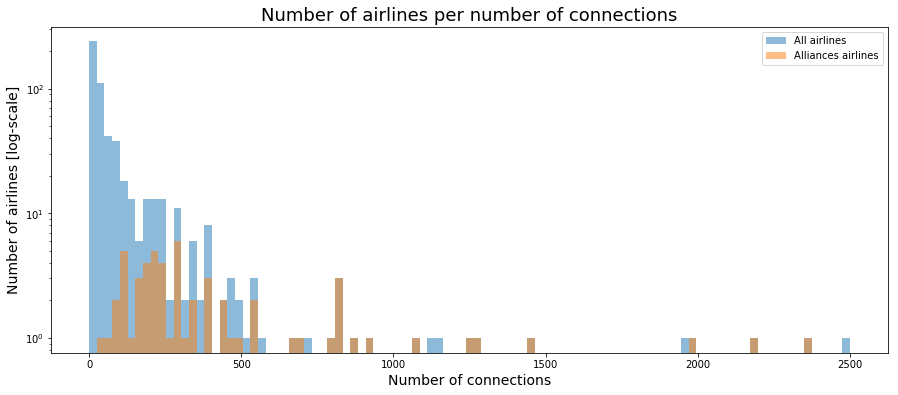

In [10]:
# create a histogram of the airline's number of flights
bins = np.linspace(0, 2500, 100)
plt.figure(figsize=(15,6))
plt.hist(routes_alce[['Airline']].groupby('Airline').size(), bins, alpha=0.5, label='All airlines')
plt.hist(routes_alce_only[['Airline']].groupby('Airline').size(), bins, alpha=0.5, label='Alliances airlines')
plt.legend(loc='upper right')
plt.title('Number of airlines per number of connections', fontsize = 18)
plt.ylabel('Number of airlines [log-scale]', fontsize = 14)
plt.xlabel('Number of connections', fontsize= 14)
plt.yscale("log")
# plt.savefig('Histogram_connections_airlines.pdf')
plt.show()

 ## Network properties of the alliance’s flight routes  <a id='Part1-2'></a>

In [11]:
def unweighted_A(A):
    '''Function to generate an unweighted adjacency matrix'''
    A_nonw = np.copy(A)
    A_nonw[A_nonw!=0]=1
    return A_nonw

In [12]:
def network_analysis(A):
    '''Function that returns several graph properties: average degree, maximum degree, 
    number of nodes, diameter of the graph and average clustering 
    coefficient of the largest connected component.
    A histogram of the degree distribution is also plotted.
    The analysis is done on the weighted and unweighted adjacency matrix.
    '''
    # create an unweighted adjacency matrix
    A_nonw = unweighted_A(A)
    
    # truncate the adjacency matrix to retain only nodes that have a connection
    A_trunc = A_nonw[~np.all(A_nonw == 0, axis=1)]
    A_alce = A_trunc[:, ~np.all(A_trunc == 0, axis=0)]
    
    # create a graph of the largest connected component
    G = nx.from_numpy_matrix(A_nonw)
    G_largest = max(nx.connected_component_subgraphs(G), key=len)
    
    # weighted graph properties
    nodes = A_alce.shape[0]
    print('\nNumber of airports connected to the alliance network: ', nodes)
    degree_w = np.sum(A, axis = 0)
    print('\nWeighted graph: Number of connections: ', np.sum(A)/2, '\naverage degree = ', np.sum(degree_w)/nodes, '\nmaximum degree', max(degree_w))
    
    # unweighted graph properties
    degree = np.sum(A_nonw, axis=0) 
    print('\nNumber of edges: ', np.sum(A_nonw)/2, '\naverage degree = ', round(np.average(degree),2), '\nmaximum degree = ', max(degree), '\nminimum degree = ', min(degree))
  
    # diameter and cluster coefficient
    print('\nDiameter of the graph: ', nx.diameter(G_largest), '\nAverage clustering coefficient: ', nx.average_clustering(G_largest))
    
    # plot the degree distribution (unweighted graph)
    plt.hist(degree, bins = 50);
    
    return


Number of airports connected to the alliance network:  3425

Weighted graph: Number of connections:  67662.0 
average degree =  39.51065693430657 
maximum degree 1826

Number of edges:  19256.5 
average degree =  11.24 
maximum degree =  248 
minimum degree =  1

Diameter of the graph:  13 
Average clustering coefficient:  0.48833620245296055


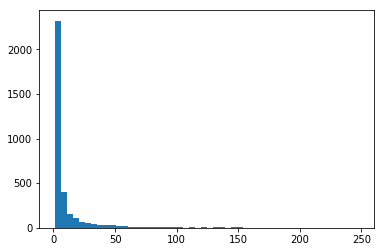

In [13]:
# Analysis on the normal adjacency matrix (as in Milestone 1)
adjacency_normal =  np.sum(adjacency, axis=2)
network_analysis(adjacency_normal)


Number of airports connected to the alliance network:  1221

Weighted graph: Number of connections:  11267.0 
average degree =  18.455364455364457 
maximum degree 587

Number of edges:  4385.0 
average degree =  2.56 
maximum degree =  226 
minimum degree =  0

Diameter of the graph:  9 
Average clustering coefficient:  0.47060521430020946


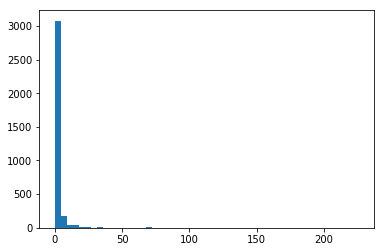

In [14]:
# Analysis on the Star Alliance network
adjacency_star =  adjacency[:,:, 2]
network_analysis(adjacency_star) 


Number of airports connected to the alliance network:  953

Weighted graph: Number of connections:  7288.0 
average degree =  15.29485834207765 
maximum degree 646

Number of edges:  3063.0 
average degree =  1.79 
maximum degree =  184 
minimum degree =  0

Diameter of the graph:  9 
Average clustering coefficient:  0.4381413258767767


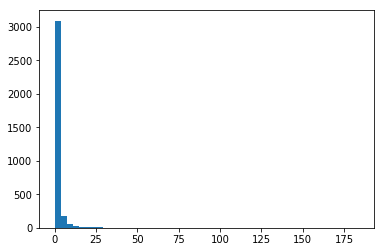

In [15]:
# Analysis on One World
adjacency_world =  adjacency[:,:, 3]
network_analysis(adjacency_world) 


Number of airports connected to the alliance network:  1081

Weighted graph: Number of connections:  10794.0 
average degree =  19.970397779833487 
maximum degree 1319

Number of edges:  4006.0 
average degree =  2.34 
maximum degree =  210 
minimum degree =  0

Diameter of the graph:  9 
Average clustering coefficient:  0.48923958526273087


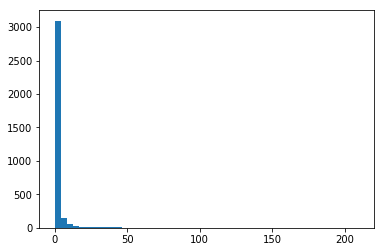

In [16]:
# Analysis on SkyTeam
adjacency_sky =  adjacency[:,:, 4]
network_analysis(adjacency_sky) 


Number of airports connected to the alliance network:  1797

Weighted graph: Number of connections:  29349.0 
average degree =  32.664440734557594 
maximum degree 1405

Number of edges:  9656.0 
average degree =  5.64 
maximum degree =  228 
minimum degree =  0

Diameter of the graph:  9 
Average clustering coefficient:  0.5317438109187125


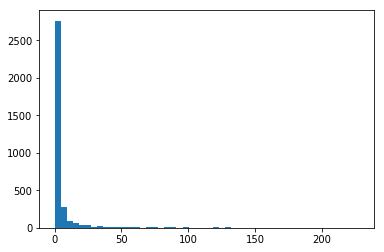

In [17]:
# Analysis on the whole alliance network
adjacency_alce = np.sum(adjacency[:,:, 2:], axis = 2)
network_analysis(adjacency_alce) 

## Proportion of airports served by alliance-airlines <a id='Part1-3'></a>

Define the number of airports served by either: SkyTeam, Star Alliance, One World, SkyTeam + One World, SkyTeam + Star Alliance, One World + Star Alliance, all, no alliance.

In [18]:
def airport_vector(A):
    '''Function that given an adjacency matrix returns a binary vector with the length of the 
    airports (nodes). 
    1 means that the node has an edge, and 0 if not.'''
    v_airport = A.any(1).astype(int)
    return v_airport

In [19]:
# generate airport vectors for the four categories
airport_star = airport_vector(adjacency_star)
airport_world = airport_vector(adjacency_world)
airport_sky = airport_vector(adjacency_sky)
airport_noalce = airport_vector(adjacency[:,:,1])

In [20]:
# generate the number of airports for the seven combinations
n_no_alliance = np.count_nonzero((airport_noalce - airport_sky- airport_star - airport_world).clip(min=0))
n_sky = np.count_nonzero((airport_sky- airport_star - airport_world).clip(min=0))
n_star = np.count_nonzero((airport_star- airport_sky - airport_world).clip(min=0))
n_world = np.count_nonzero((airport_world- airport_star - airport_sky).clip(min=0))
n_sky_star = np.sum((airport_sky + airport_star - airport_world) == 2)
n_sky_world = np.sum((airport_sky - airport_star + airport_world) == 2)
n_world_star = np.sum((airport_world + airport_star - airport_sky) == 2)
n_all = np.sum((airport_sky + airport_star + airport_world) == 3)

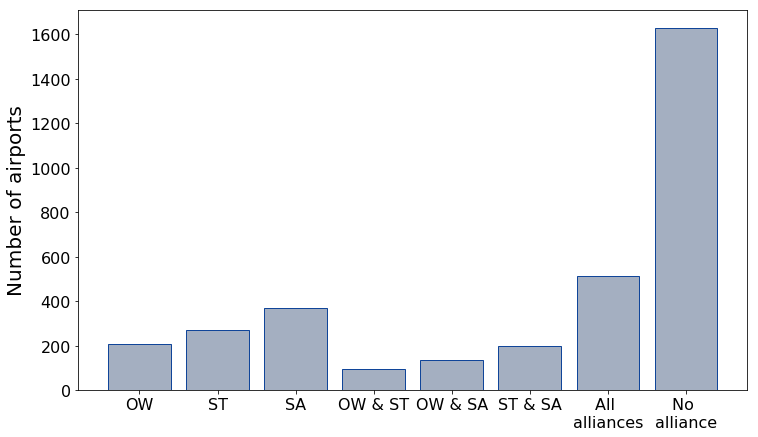

In [21]:
n_airports = [n_world, n_sky, n_star, n_sky_world, n_world_star, n_sky_star, n_all, n_no_alliance]
airport_label = ['OW', 'ST', 'SA', 'OW & ST', 
                 'OW & SA', 'ST & SA', 'All \nalliances', 'No \nalliance']
plt.figure(figsize=(12,7))
plt.bar(np.arange(1,9), n_airports, tick_label = airport_label, color = '#a4afc1', edgecolor = '#104599')
plt.ylabel('Number of airports', fontsize =  20)
plt.tick_params(labelsize=16)
plt.savefig('Number_airports_alliances.pdf')

 The  majority  of  airports  in  the  alliancenetwork are only served by one alliance (852 airports in total).  However, a lot of airports are also served by all the three alliances, and interestingly this number is significantly higher than the numberof airports that are served by 2 alliances (432 compared  to  513  airports).

## 2- Is the alliance business a hub thing? <a id='Part2'></a>

We label the airports by the number of alliances flights that serve it (0, 1, 2 or 3) and we analyze the correlation between this number and the degree of the airport. We expect that a lower degree airport is less likely to be connected to the alliance network than big hubs.

We do the correlation once using the degree of the whole flight network and once using the degree of only the alliance network.

In [22]:
# create an airport vector with the number of alliances serving it
airport_num_alce = airport_world + airport_sky + airport_star
print('Airports served by 1, 2 and 3 alliances: ', np.sum(airport_num_alce == 1), np.sum(airport_num_alce == 2), np.sum(airport_num_alce == 3))

Airports served by 1, 2 and 3 alliances:  852 432 513


In [23]:
# degree calculation on the whole network
A_nonw = unweighted_A(adjacency_normal)
degree_all = np.sum(A_nonw, axis=0) 
# degree calculation on the alliance's network
A_nonw_alce = unweighted_A(adjacency_alce)
degree_alce = np.sum(A_nonw_alce, axis=0) 

# delete the zero degree airports for the alliance network (since anyway the number of alliances is zero here)
airport_alce_only = airport_num_alce[airport_num_alce!=0]
degree_alce_only = degree_alce[airport_num_alce!=0]

Text(0.5, 0.03, 'Number of alliances per airport')

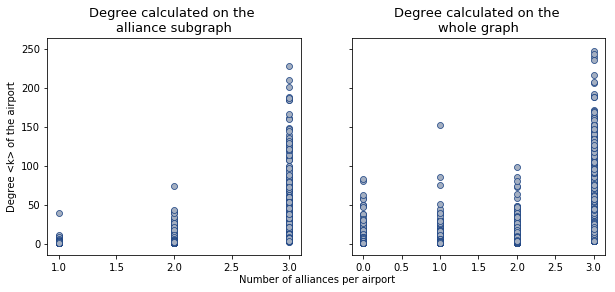

In [24]:
# plot the correlation
f, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
sns.scatterplot(x = airport_alce_only, y = degree_alce_only, ax = axes[0], color = '#a4afc1', edgecolor = '#1e4584')
sns.scatterplot(x = airport_num_alce, y = degree_all, ax = axes[1],  color = '#a4afc1', edgecolor = '#1e4584')
axes[0].set_title('Degree calculated on the \nalliance subgraph', fontsize = 13)
axes[1].set_title('Degree calculated on the \nwhole graph', fontsize = 13)
axes[0].set_ylabel('Degree <k> of the airport')
f.text(0.5, 0.03, 'Number of alliances per airport', ha='center')
#plt.savefig('degree_numalce.pdf')

In [25]:
# find the outlier airport on the second plot (alce == 1 and degree above 100) and the corresponding alliance
df_all = pd.DataFrame({'num_alce': airport_num_alce, 'degree': degree_all})
df_all[(df_all.num_alce == 1) & (df_all.degree > 90)]
print(airportsID[airportsID.airportsID == 488]) # Stansted

# it is One World with 2 flights
np.sum(adjacency[488,:,3])

         airportsID IATA
Airport                 
STN             488  STN


2

## 3- Which part of the world is dominated by who, and what is a likely expansion? <a id='Part3'></a>

#### Geographic distribution of the alliances <a id='Part3-1'></a>

Each airline has a country of origin, and we can also associate each airport to a country. We then start the analysis by identifying the major alliance for each airport (for each airport count the number of edges for each alliance and attribute the airport to the alliance with the maximum count, in case of a tie, the airport is labelled by the two or three major alliances). We then have a graph with 3 labels, and nodes with an unknown label, if not served by an alliance company. A validation step of this approach is then to see whether the country of the airport is the same as the country of one of the airlines inside the alliance. When plotting the result on the worldmap, we might see geographic differences between the alliances.

In [26]:
# WORLD MAP PLOT AND COUNTRY ATTRIBUTION

In [27]:
# create dataframe with the airlines and their respective country 
airl_alliances  = pd.merge(alliances, airlines, left_on='IATA', right_on='IATA', how = 'left')[['Alliance', 'Name', 'IATA', 'Country']]

In [28]:
# attribute the countries to an alliance or combination of alliances
country_attribution = pd.DataFrame(data={'Country': [], 'ColorCode': []});
for country in airl_alliances.Country.unique():
    alliances = airl_alliances[airl_alliances.Country==country].Alliance.unique()
    if 'Star Alliance' in alliances:
        if 'One World' in alliances:
            if 'SkyTeam' in alliances :
                colorCode = 7
            else :
                colorCode = 4
        elif 'SkyTeam' in alliances :
            coloCode = 6
        else :
            colorCode = 1
    elif 'One World' in alliances :
        if 'SkyTeam' in alliances :
            colorCode = 5
        else :
            colorCode = 2
    elif 'SkyTeam' in alliances :
        colorCode = 3
    country_attribution = country_attribution.append({'Country':country, 'ColorCode':colorCode},ignore_index=True)

country_attribution = country_attribution.set_index('Country')
country_attribution.head()

ColorCode
Country               
Slovenia           1.0
Greece             1.0
Canada             1.0
China              1.0
New Zealand        1.0

In [29]:
# attribute the airports to an alliance or combination of alliances
airport_attribution = airportsID.copy()
airport_attribution['Alliance'] = np.nan

for airport in airport_attribution.index :
    idx = int(airport_attribution.loc[airport].airportsID)
    SA = np.sum(adjacency[idx, :, 2]) + np.sum(adjacency[:, idx, 2])
    OW = np.sum(adjacency[idx, :, 3]) + np.sum(adjacency[:, idx, 3])
    ST = np.sum(adjacency[idx, :, 4]) + np.sum(adjacency[:, idx, 4])
    if (SA==OW) & (SA==ST):
        if SA == 0:
            airport_attribution.loc[airport,'Alliance']= "No Alliance"
        else:
            airport_attribution.loc[airport,'Alliance']= 7 
    elif (SA == OW) & (SA == max(SA, OW, ST)):
        airport_attribution.loc[airport,'Alliance']= 4
    elif (SA == ST) & (SA == max(SA, OW, ST)):
        airport_attribution.loc[airport,'Alliance']= 6
    elif (OW == ST) & (ST == max(SA, OW, ST)):
        airport_attribution.loc[airport,'Alliance'] = 5
    elif SA==max(SA,OW,ST) :
        airport_attribution.loc[airport,'Alliance']= 1
    elif OW==max(SA,OW,ST) :
        airport_attribution.loc[airport,'Alliance']= 2
    elif ST==max(SA,OW,ST) :
        airport_attribution.loc[airport,'Alliance']= 3

In [32]:
# add the country information to the dataframe
country_ref=airports[['Country','IATA']]
country_ref.rename(columns={"IATA": "Airport"},inplace=True)
country_ref.set_index('Airport', inplace=True)

airport_attribution = pd.merge(airport_attribution, country_ref,  on='Airport', how  ='left')
#airport_attribution.drop(columns=['airportsID'], inplace=True)

airport_attribution.head()

airportsID IATA     Alliance     Country
Airport                                          
ASF               0  ASF            7      Russia
CEK               1  CEK            2      Russia
DME               2  DME            2      Russia
EGO               3  EGO  No Alliance      Russia
GYD               4  GYD            3  Azerbaijan

In [33]:
def compare(alliance, airport_attribution, country_attribution):
    '''Function that compares the countries where the alliance has an airline with a country
    of origin and the countries where the alliance dominates airports.'''
    
    if alliance=='Star Alliance' :
        val=[1,4,6,7]
    elif alliance=='One World' :
        val=[2,4,5,7]
    elif alliance=='SkyTeam' :
        val=[3,5,6,7]
    else :
        print('The alliance parameter is not correct.')
        return
    
    print('Comparison between country and airport attribution for '+alliance)
    print()
    
    list1 = list(country_attribution[country_attribution['ColorCode'].isin(val)].index)
    print('Countries where the companies of the alliance have their basis :',len(list1))
    print(list1)
    print()
    
    list2 = list(airport_attribution[airport_attribution['Alliance'].isin(val)].Country.unique())
    print('Countries where the alliance dominates airports :',len(list2))
    print(list2)
    print()
    
    inBoth=set(list1) & set(list2)
    print('Countries that are in both lists :',len(inBoth))
    print(inBoth)

In [34]:
compare('Star Alliance',airport_attribution,country_attribution)

Comparison between country and airport attribution for Star Alliance

Countries where the companies of the alliance have their basis : 25
['Slovenia', 'Greece', 'Canada', 'China', 'New Zealand', 'Japan', 'Republic of Korea', 'United States', 'Austria', 'AVIANCA', 'Belgium', 'Panama', 'Croatia', 'Egypt', 'Ethiopia', 'Taiwan', 'Poland', 'Germany', 'Sweden', 'Singapore', 'South Africa', 'Switzerland', 'Portugal', 'Thailand', 'Turkey']

Countries where the alliance dominates airports : 142
['Russia', "Cote d'Ivoire", 'Ghana', 'Mali', 'Benin', 'Senegal', 'Togo', 'Niger', 'Burkina Faso', 'Colombia', 'Switzerland', 'Cyprus', 'Egypt', 'Sweden', 'Norway', 'Finland', 'Brazil', 'United States', 'Gambia', 'Guinea', 'Cameroon', 'Sierra Leone', 'Nigeria', 'Guinea-Bissau', 'Canada', 'Djibouti', 'Somalia', 'Thailand', 'Japan', 'Singapore', 'Germany', 'Austria', 'Croatia', 'Bahamas', 'Belgium', 'Turkey', 'Aruba', 'Netherlands Antilles', 'Venezuela', 'China', nan, 'Northern Mariana Islands', 'Taiwan', '

In [35]:
compare('One World',airport_attribution,country_attribution)

Comparison between country and airport attribution for One World

Countries where the companies of the alliance have their basis : 15
['Japan', 'Republic of Korea', 'United States', 'Germany', 'Russia', 'Spain', 'United Kingdom', 'Hong Kong SAR of China', 'Finland', 'Chile', 'Malaysia', 'Australia', 'Qatar', 'Jordan', 'Sri Lanka']

Countries where the alliance dominates airports : 96
['Russia', 'Peru', 'Ecuador', 'Italy', 'Spain', 'Finland', 'United Arab Emirates', 'Philippines', 'United States', 'Gambia', 'United Kingdom', 'Australia', 'Hong Kong', 'Thailand', 'Malaysia', 'Germany', 'Austria', 'Bahamas', 'Morocco', 'Netherlands Antilles', 'Venezuela', 'Uzbekistan', 'Montenegro', 'Antigua and Barbuda', 'Dominica', 'India', 'Bangladesh', 'Oman', 'Mexico', 'Turkey', 'Egypt', 'Greece', 'Portugal', 'Brunei', 'Chile', 'Paraguay', 'Belize', 'Honduras', 'Burma', 'Japan', 'Jamaica', 'Dominican Republic', 'Trinidad and Tobago', 'Tajikistan', 'Argentina', 'Jordan', nan, 'British Virgin Islands',

In [36]:
compare('SkyTeam',airport_attribution,country_attribution)

Comparison between country and airport attribution for SkyTeam

Countries where the companies of the alliance have their basis : 15
['United States', 'Russia', 'Argentina', 'Mexico', 'Spain', 'France', 'Italy', 'Czech Republic', 'Indonesia', 'Kenya', 'Netherlands', 'Lebanon', 'Saudi Arabia', 'Romania', 'Vietnam']

Countries where the alliance dominates airports : 86
['Russia', 'Azerbaijan', 'Niger', 'Italy', 'France', 'United Kingdom', 'Norway', 'Philippines', 'Brazil', 'United States', 'Liberia', 'Djibouti', 'Kenya', 'China', 'Cambodia', 'Burma', 'Vietnam', 'Taiwan', 'Netherlands', 'Morocco', 'Netherlands Antilles', 'Uzbekistan', 'French Guiana', 'Martinique', 'Guadeloupe', 'Dominican Republic', 'Saint Lucia', 'South Korea', nan, 'Bangladesh', 'Saudi Arabia', 'Argentina', 'Mexico', 'Cuba', 'India', 'Pakistan', 'Algeria', 'Germany', 'Czech Republic', 'Tunisia', 'Indonesia', 'Paraguay', 'Uruguay', 'Armenia', 'Latvia', 'Haiti', 'Suriname', 'Tajikistan', 'Kyrgyzstan', 'Thailand', 'Romania

For the visualisation, we can associate a color for each airport depending on the proportion of the three alliances. 

In [30]:
airport_colors = [None] * airportsID.shape[0]

for airport in airportsID.airportsID :
    SA = np.sum(adjacency[airport, :, 2])
    OW = np.sum(adjacency[airport, :, 3])
    ST = np.sum(adjacency[airport, :, 4])
    p = np.array([SA, OW, ST])
    norm = np.linalg.norm(p)
    if (norm != 0):
        p = p/norm*255
    airport_colors[airport]='#%02x%02x%02x'%(int(p[0]), int(p[1]), int(p[2]))

In [56]:
mapColorAiports = folium.Map(tiles='cartodbdark_matter',  location=[14, 10], zoom_start=1.5)
for idx,row in geoData.iterrows():
    #print(row.alliance)
    color = airport_colors[idx]
    if color =="#000000":
        r = 2
    else:
        r = 3
    if pd.isna(row.Latitude) is False:
        folium.CircleMarker(
            location=[row.Latitude, row.Longitude],
            radius=r,
            color=color,
            stroke=False,
            fill=True,
            fill_opacity=0.6,
            tooltip=row.Name
        ).add_to(mapColorAiports)
mapColorAiports

On the map, if the airport is more red, it means that the proportion of flight of <span style="background:#FF0000">Sky Alliance</span> is more important that the other alliances. The same way, the green is asociated with <span style="background:#00FF00">One World</span> and blue with <span style="background:#0000FF">SkyTeam</span>.

### Airport expansion of the alliances predicted through label propagation  <a id='Part3-2'></a>

We study the expansion of the alliances through label propagation. The underlying concept is that airport not yet served by an alliance will be served by the alliance occurring with the highest frequency among its neighbours. Each neighbour has one vote, independent of how connected it is, and an airport may be labelled by 2 or 3 alliances if there is a tie among the node degree between the alliances (at the step of the initial labelling) or a tie between the vote comparison (at the step of attributing the label) (see illustration below).

In a first step we validate our algorithm by only working on the alliance network and by randomly unlabelling half of the nodes for which we know the major alliance serving it. This allows us to get some accuracy scores and to see if our algorithm is valid. In a second step, we keep all the airports labelled which are served by an alliance and through label propagation we predict the likely alliance expansion (we predict a label for all the airports inside our largest connected component). 

<img src="image_illustration/label_propa_algo.png">

First, we create a new airport attribution matrix with dummy columns for each alliance, filled with 1 if that alliance is a major alliance for this airport.

In [37]:
# initialize the dummy dataframe
airport_attribution_dummy = pd.DataFrame({'airport': airportsID.index, 'airportsID': airportsID.airportsID,
                                        'Star Alliance': np.zeros(airportsID.shape[0]), 'One World': np.zeros(airportsID.shape[0]),
                                        'SkyTeam': np.zeros(airportsID.shape[0])})

# fill in the airport-alliance attribution
for airport in airport_attribution.index :
    idx = int(airport_attribution.loc[airport].airportsID)
    SA = np.sum(adjacency[idx, :, 2]) + np.sum(adjacency[:, idx, 2])
    OW = np.sum(adjacency[idx, :, 3]) + np.sum(adjacency[:, idx, 3])
    ST = np.sum(adjacency[idx, :, 4]) + np.sum(adjacency[:, idx, 4])
    if (SA==OW) & (SA==ST):
        if SA != 0:
            airport_attribution_dummy.loc[airport,'Star Alliance'] += 1
            airport_attribution_dummy.loc[airport,'One World'] += 1
            airport_attribution_dummy.loc[airport,'SkyTeam'] += 1
    elif (SA == OW) & (SA == max(SA, OW, ST)):
        airport_attribution_dummy.loc[airport,'Star Alliance'] += 1
        airport_attribution_dummy.loc[airport,'One World'] += 1
    elif (SA == ST) & (SA == max(SA, OW, ST)):
        airport_attribution_dummy.loc[airport,'Star Alliance'] += 1
        airport_attribution_dummy.loc[airport,'SkyTeam'] += 1
    elif (OW == ST) & (ST == max(SA, OW, ST)):
        airport_attribution_dummy.loc[airport,'One World'] += 1
        airport_attribution_dummy.loc[airport,'SkyTeam'] += 1
    elif SA==max(SA,OW,ST) :
        airport_attribution_dummy.loc[airport,'Star Alliance'] += 1
    elif OW==max(SA,OW,ST) :
        airport_attribution_dummy.loc[airport,'One World'] += 1
    elif ST==max(SA,OW,ST) :
        airport_attribution_dummy.loc[airport,'SkyTeam'] += 1
        
airport_attribution_dummy.head()

airport  airportsID  Star Alliance  One World  SkyTeam
Airport                                                       
ASF         ASF           0            1.0        1.0      1.0
CEK         CEK           1            0.0        1.0      0.0
DME         DME           2            0.0        1.0      0.0
EGO         EGO           3            0.0        0.0      0.0
GYD         GYD           4            0.0        0.0      1.0

### Validation on the alliance dataset by unlabelling half of the airports

In [38]:
# prepare the dataset for the label propagation algorithm
airport_alce = airport_attribution_dummy.copy()
airport_alce.index = airportsID.airportsID

# First we only work on airports with a label 
airport_alce = airport_alce[airport_alce[['Star Alliance', 'One World', 'SkyTeam']].sum(axis=1) != 0].copy()
# add a column with a label 1 if labelled or 0 if unlabelled, and we choose to unlabel 1/2
airport_alce['labelled'] = np.random.choice([0, 1], size=(airport_alce.shape[0],), p=[1./2, 1./2])
# add a column to indicate whether an unlabelled airport needs to be labelled
airport_alce['tolabel'] = np.zeros(airport_alce.shape[0])
airport_alce['tolabel'][airport_alce.labelled==0] = 1
# add new columns for the predicted alliance for the unlabelled airports
airport_alce['Star Alliance pred'] = np.zeros(airport_alce.shape[0])
airport_alce['One World pred'] = np.zeros(airport_alce.shape[0])
airport_alce['SkyTeam pred'] = np.zeros(airport_alce.shape[0])
airport_alce.head()

airport  airportsID  Star Alliance  One World  SkyTeam  labelled  \
airportsID                                                                    
0              ASF           0            1.0        1.0      1.0         0   
1              CEK           1            0.0        1.0      0.0         0   
2              DME           2            0.0        1.0      0.0         0   
4              GYD           4            0.0        0.0      1.0         0   
5              KGD           5            0.0        1.0      0.0         1   

            tolabel  Star Alliance pred  One World pred  SkyTeam pred  
airportsID                                                             
0               1.0                 0.0             0.0           0.0  
1               1.0                 0.0             0.0           0.0  
2               1.0                 0.0             0.0           0.0  
4               1.0                 0.0             0.0           0.0  
5               0.0                 0.0             0.0           0.0

In [39]:
def propagate_labels(airport_data, adjacency):
    '''Function that labels unlabelled airports with an alliance or a combination of alliances.
    airport_data: dataframe with the alliance-airport information
    adjacency: unweighted adjacency matrix.'''
   
    airport_attr = airport_data.copy()
    list_airport_to_label = list(airport_attr[airport_attr.tolabel == 1].airportsID)
    while list_airport_to_label != [] :
        # we randomly chose an airport
        number_airport=len(list_airport_to_label)
        if number_airport>1:
            airport= list_airport_to_label[random.randint(0,number_airport-1)]
        else:
            airport= list_airport_to_label[0]
            
        # find the neighbours of the airport
        neighbours = np.argwhere(adjacency[airport,]!=0)
        neighbours = [item for sublist in neighbours for item in sublist] # unlist neighbours
        
        # sum up the alliances labels of the labelled neighbour nodes
        values = airport_attr[['Star Alliance', 'One World', 'SkyTeam']][(airport_attr.airportsID.isin(neighbours)) & (airport_attr.labelled == 1)].sum()
        
        # add the votes of the newly predicted neighbour airports
        values_neigh_pred = list(airport_attr[['Star Alliance pred', 'One World pred', 'SkyTeam pred']][(airport_attr.airportsID.isin(neighbours)) & (airport_attr.labelled == 0)].sum())
        values = values+values_neigh_pred
        
        # if there is no majority alliance, skip this round
        if sum(values) == 0:
            continue
        # get the major alliance
        alliance = list(values[values == max(values)].index)
        # add 'pred' after the alliance to match the column name
        alliance_pred = [s + ' pred' for s in alliance]
        # attribute the label
        airport_attr.loc[airport, alliance_pred] = 1
        
        # remove the 'tolabel' for this airport
        airport_attr.loc[airport, 'tolabel'] = 0
        list_airport_to_label = list(airport_attr[airport_attr.tolabel == 1].airportsID)

    return airport_attr

In [40]:
# test the algorithm using the unweighted alliance adjacency matrix
adjacency_alce = np.sum(adjacency[:,:,2:], axis=2)
A_nonw_alce = unweighted_A(adjacency_alce)
airport_attr = propagate_labels(airport_alce, A_nonw_alce)

In [41]:
# calculate the accuracy scores
'''Since we allow the airports to have multiple labels,  we calculate a score once for every 
alliance and an overall accuracy score.  
Here is an example to illustrate this:  if an airport has a SA and a ST label, 
and our algorithm predicts only SA, their would be a full accuracy score for SA alone, 
but 0 for ST and the overall correctness. ''' 

# get the predicted airports
airport_pred = airport_attr[airport_attr.labelled == 0]
num_pred = airport_pred.shape[0]
print('Number of airports for which a label is predicted', num_pred)
print('Total number of airports', airport_attr.shape[0])

print('correctness for the individual alliances')
print('Star Alliance', sum((airport_pred['Star Alliance'] == airport_pred['Star Alliance pred']))/num_pred)
print('One World', sum((airport_pred['One World'] == airport_pred['One World pred']))/num_pred)
print('SkyTeam', sum((airport_pred['SkyTeam'] == airport_pred['SkyTeam pred']))/num_pred)

#overall correctness
true_val = list(zip(airport_pred['Star Alliance'], airport_pred['One World'], airport_pred['SkyTeam'])) 
pred_val = list(zip(airport_pred['Star Alliance pred'], airport_pred['One World pred'], airport_pred['SkyTeam pred']))
accuracy_val = sum(i == j for i,j in zip(true_val, pred_val))
print('Overall correctness: ', accuracy_val, 'Accuracy (%): ', accuracy_val/num_pred)

Number of airports for which a label is predicted 889
Total number of airports 1797
correctness for the individual alliances
Star Alliance 0.843644544431946
One World 0.8458942632170978
SkyTeam 0.8627671541057368
Overall correctness:  628 Accuracy (%):  0.7064116985376828


### Predicting labels for all the airports inside the largest connected component

In [42]:
# prepare the dataframe
airport_all = airport_attribution_dummy.copy()
airport_all.index = airportsID.airportsID

# add a column labelled with 1/True if the airport is served by an alliance and 0/False if not
airport_all['labelled'] = airport_all[['Star Alliance', 'One World', 'SkyTeam']].sum(axis=1) != 0

# add a column to indicate whether an unlabelled airport (airport with no alliance) needs to be labelled
airport_all['tolabel'] = np.zeros(airport_all.shape[0])
airport_all['tolabel'][~airport_all.labelled] = 1 

# add new columns for the predicted alliance for the unlabelled airports
airport_all['Star Alliance pred'] = np.zeros(airport_all.shape[0])
airport_all['One World pred'] = np.zeros(airport_all.shape[0])
airport_all['SkyTeam pred'] = np.zeros(airport_all.shape[0])
airport_all.head()

airport  airportsID  Star Alliance  One World  SkyTeam  labelled  \
airportsID                                                                    
0              ASF           0            1.0        1.0      1.0      True   
1              CEK           1            0.0        1.0      0.0      True   
2              DME           2            0.0        1.0      0.0      True   
3              EGO           3            0.0        0.0      0.0     False   
4              GYD           4            0.0        0.0      1.0      True   

            tolabel  Star Alliance pred  One World pred  SkyTeam pred  
airportsID                                                             
0               0.0                 0.0             0.0           0.0  
1               0.0                 0.0             0.0           0.0  
2               0.0                 0.0             0.0           0.0  
3               1.0                 0.0             0.0           0.0  
4               0.0                 0.0             0.0           0.0

In [43]:
# only use the largest connected compound and set 'tolabel' to 2 for airports outside the cc

# find the largest component using the normal unweighted adjacency matrix
adjacency_normal =  np.sum(adjacency, axis=2)
A_nonw = unweighted_A(adjacency_normal)
G = nx.from_numpy_matrix(A_nonw)
G_largest = max(nx.connected_component_subgraphs(G), key=len)

# airports inside the largest connected component
airports_cc = list(G_largest.nodes)

# label other airports to 2
airport_all['tolabel'][~airport_all.airportsID.isin(airports_cc)] = 2
print('Number of airports not inside the largest connected component: ', sum(airport_all.tolabel == 2))

Number of airports not inside the largest connected component:  28


In [44]:
# apply the label propagation algorithm 
airport_attr_all = propagate_labels(airport_all, A_nonw)

In [45]:
# example of airports with a prediction
airport_attr_all[airport_attr_all.labelled == False].head(5)

airport  airportsID  Star Alliance  One World  SkyTeam  labelled  \
airportsID                                                                    
3              EGO           3            0.0        0.0      0.0     False   
14             TGK          14            0.0        0.0      0.0     False   
15             UUA          15            0.0        0.0      0.0     False   
19             KCK          19            0.0        0.0      0.0     False   
20             MJZ          20            0.0        0.0      0.0     False   

            tolabel  Star Alliance pred  One World pred  SkyTeam pred  
airportsID                                                             
3               0.0                 0.0             0.0           1.0  
14              0.0                 0.0             1.0           0.0  
15              0.0                 0.0             1.0           1.0  
19              0.0                 0.0             1.0           0.0  
20              0.0                 0.0             1.0           0.0

KCK: Kirensk Airport (Russia) EGO: Belgorod (Russia) TGK: Russia UUA: Russia

In [46]:
# create a dataframe with all the airports with their label, predicted and true mixed
airport_alce_int = airport_attr_all.copy()
airport_alce_int['SA'] = airport_alce_int['Star Alliance'] + airport_alce_int['Star Alliance pred']
airport_alce_int['OW'] = airport_alce_int['One World'] + airport_alce_int['One World pred']
airport_alce_int['ST'] = airport_alce_int['SkyTeam'] + airport_alce_int['SkyTeam pred']
airport_alce_all = airport_alce_int[['airport', 'airportsID', 'SA', 'OW', 'ST']]
airport_alce_all.drop(columns=['airportsID'], inplace=True)
airport_alce_all.head()

airport   SA   OW   ST
airportsID                       
0              ASF  1.0  1.0  1.0
1              CEK  0.0  1.0  0.0
2              DME  0.0  1.0  0.0
3              EGO  0.0  0.0  1.0
4              GYD  0.0  0.0  1.0

New airports have now been assigned to new alliance thanks to the label propagation. We can now visualize these new attribution on the map. For exemple, let's take the evolution of the Sky Alliance control.

In [55]:
m_SA_pred = folium.Map(tiles='cartodbdark_matter',  location=[14, 10], zoom_start=1.5)
for idx,row in geoData.iterrows():
    if pd.isna(row.Latitude) is False:
        if airport_attr_all.loc[idx,"Star Alliance"] == 1:
            folium.CircleMarker(
                location=[row.Latitude, row.Longitude],
                radius=2*r,
                color='#ff0000',
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                tooltip=row.Name
            ).add_to(m_SA_pred)
        elif airport_attr_all.loc[idx,"Star Alliance pred"] == 1:
            folium.CircleMarker(
                location=[row.Latitude, row.Longitude],
                radius=2*r,
                color='#ffffff',
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                tooltip=row.Name
            ).add_to(m_SA_pred)
m_SA_pred.save("MapPredicSA.html")
m_SA_pred

Here, the <span style="background:#FF0000">red</span> points represents the current airports controled by the alliance and the <span style="background:#FFFFFF">white</span> points represents which airport could be won. It is a significative improvement of offer for the alliance as it cover a lot of the aiport that were previoully missing.

## Assign airlines to alliances (not belonging to them) <a id='Part3-3'></a>

From the previous results, we can assign alliances labels to airlines that are not part of the alliances. We do this by selecting the alliance with the highest frequency when counting together all the airports that the airline is serving. In a first phase, we test this on the  two airlines that joined the alliances after 2014 and that we did not include since our dataset is from 2014 (Air India and Oceanair/Avianca Brazil).

In [47]:
def alliance_to_airlines(airline_list, routes, airport_alce_data):

    '''assigns an alliance label to airlines according to the label of the airports 
    they are serving. For each airline, the function first gets the list of airports 
    it is serving, and then sums up the alliances of these airports and returns 
    the majority label.
    airline_list: list of airlines for which an alliance is attributed
    routes: original routes dataset
    airport_alce_data: dataset with all the airports and their predicted alliance label'''
    
    alce_label = []
    
    for i, airline in enumerate(airline_list):

        # get the list of airports the airlines are serving
        source_air = routes['SourceAirport'][routes.Airline == airline].values
        dest_air = routes['DestinationAirport'][routes.Airline == airline].values
        airports_airline = list(set(list(source_air) + list(dest_air)))
    
        # sum up the alliance labels of this airports
        values = airport_alce_data[['SA', 'OW', 'ST']][(airport_alce_data.airport.isin(airports_airline))].sum()
        alce_label.append(np.argmax(values))
        
    result = pd.DataFrame({'airline': airline_list, 'predicted alliance': alce_label})
    return result

In [48]:
# check for the airlines that joined between 2014 and today
# Air India Limited (Air India) (AI) and Oceanair (Avianca Brazil) (O6) 
airline_alce = alliance_to_airlines(['AI', 'O6'], routes, airport_alce_all)
airline_alce

airline predicted alliance
0      AI                 SA
1      O6                 SA

Both airlines joined the Star Alliance, thus the prediction is correct!

Assign other big airlines to alliances

In [49]:
airline_alce = alliance_to_airlines(['B6', 'B6', 'FR', 'US', 'EK', 'EY', 'U2', 'W6', 'AK', 'VS', 'WN'], routes, airport_alce_all)
airline_alce

airline predicted alliance
0       B6                 ST
1       B6                 ST
2       FR                 OW
3       US                 ST
4       EK                 SA
5       EY                 SA
6       U2                 SA
7       W6                 SA
8       AK                 ST
9       VS                 ST
10      WN                 ST

## 4- Can the alliances be predicted from the construction of an airline network? <a id='Part4'></a>

- We construct the airline network by giving different weights to the edges with respect to competitive alliances flights between two airports, and consecutive flights of the common alliance members. On this graph we see if we can cluster the airlines into the 3 major alliances (we probably tune the constructing weights parameters to make this happen). In this approach, we can also see if some airlines not yet part of an alliance are likely to become part of one. Again, we can validate that by checking recent fusions and negotiations.

- From this network, we could also check if we can identify the new alliances that formed (Vanilla Alliance, U-FLY Alliance, Value Aliance).